In [ ]:
# %pip install pandas numpy
# %pip install tensorflow
# %pip install torch torchvision torchaudio
# %pip install scikit-learn
# %pip install RDKit
# %pip install matplotlib networkx
# %pip install dgllife
# %pip install torch_geometric
# %pip install torch torchvision torchaudio
# %pip install deepchem
# %pip install deepchem\[torch\]
# %pip install transformers

# | Import data

In [12]:
import pandas as pd
tox_data = pd.read_csv('../data/tox21.csv')
tox_data.head(2)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O


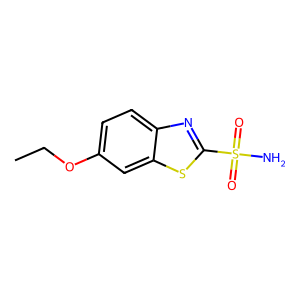

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt

smiles_sample = tox_data['smiles'][0].strip()
mol = Chem.MolFromSmiles(smiles_sample)
Draw.MolToImage(mol)


In [14]:
# for atom in mol.GetAtoms():
#     print(f"Atom index: {atom.GetIdx()}")
#     print(f" - Symbol: {atom.GetSymbol()}")
#     print(f" - Atomic Number: {atom.GetAtomicNum()}")
#     print(f" - Formal Charge: {atom.GetFormalCharge()}")
#     print(f" - Is Aromatic: {atom.GetIsAromatic()}")
#     print(f" - Hybridization: {atom.GetHybridization()}")
#     print(f" - Degree: {atom.GetDegree()}")  # number of connected atoms
#     print(f" - Implicit Hs: {atom.GetNumImplicitHs()}")
#     print(f" - Explicit Hs: {atom.GetTotalNumHs()}")
#     print(f" - In Ring: {atom.IsInRing()}")
#     print(f" - Chirality: {atom.GetChiralTag()}")
#     print()

#### Show as graph

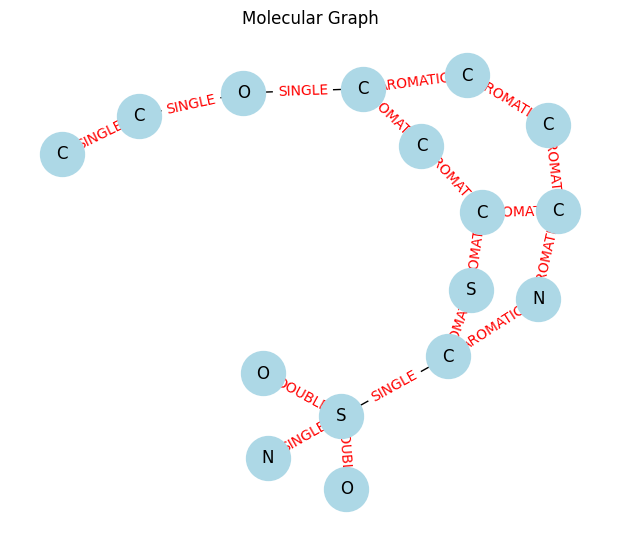

In [3]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    
    # 添加原子节点
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        G.add_node(idx, label=atom.GetSymbol())
    
    # 添加键（边）
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bond_type = str(bond.GetBondType())
        G.add_edge(a1, a2, label=bond_type)
    
    return G, mol

def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(6, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1000, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Molecular Graph")
    plt.axis('off')
    plt.show()
    
    
G, mol = smiles_to_graph(smiles_sample)
draw_graph(G)

# | Model

## 1. GCN
(Hard to use) <br>
DeepChem: https://github.com/deepchem/deepchem?tab=readme-ov-file#installation

In [ ]:
# %pip uninstall dgl -y
# %pip install dgl==1.1.2 -f https://data.dgl.ai/wheels/repo.html

In [6]:
import torch
import torch.nn as nn
from deepchem.models.torch_models.layers import GraphConv, GraphGather, GraphPool

In [7]:
tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
         'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

In [ ]:
# from rdkit import Chem

# # Drop rows with missing or invalid SMILES
# df = tox_data.dropna(subset=['smiles'])
# df = df[df['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# # Convert labels to floats, and force non-numeric values (e.g., "nan") to np.nan
# tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
#          'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
# df[tasks] = df[tasks].apply(pd.to_numeric, errors='coerce')

# # Save cleaned file
# df.to_csv('tox21_cleaned.csv', index=False)

In [24]:
# import deepchem as dc
# tasks=['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
#            'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

# # Load your dataset
# loader = dc.data.CSVLoader(
#     tasks=['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
#            'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'],
#     feature_field="smiles",
#     featurizer=dc.feat.MolGraphConvFeaturizer()
# )
# # dataset = loader.create_dataset('../data/tox21.csv')
# dataset = loader.create_dataset('./tox21_cleaned.csv')
# splitter = dc.splits.ScaffoldSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

In [75]:
# import deepchem as dc
# from typing import List, Tuple, Union, Optional
# import os
# import pandas as pd
# # from deepchem.molnet.load_function import TransformerGenerator
# from deepchem.data import Dataset

# # Custom TOX21-style loader for your own dataset
# def load_custom_dataset(
#     csv_path: str,
#     featurizer: Union[dc.feat.Featurizer, str] = 'GraphConv',
#     splitter: Union[dc.splits.Splitter, str, None] = 'scaffold',
#     transformers = ['balancing'],
#     reload: bool = False,
#     data_dir: Optional[str] = None,
#     save_dir: Optional[str] = None,
#     tasks: Optional[List[str]] = None,
#     smiles_field: str = 'smiles',
#     **kwargs
# ) -> Tuple[List[str], Tuple[Dataset, ...], List[dc.trans.Transformer]]:

#     # Load data to get task columns if not specified
#     df = pd.read_csv(csv_path)
#     if tasks is None:
#         tasks = [col for col in df.columns if col != smiles_field]

#     # Define featurizer
#     if isinstance(featurizer, str):
#         if featurizer.lower() == 'graphconv':
#             featurizer_obj = dc.feat.MolGraphConvFeaturizer(**kwargs)
#         elif featurizer.lower() == 'ecfp':
#             featurizer_obj = dc.feat.CircularFingerprint(size=1024)
#         else:
#             raise ValueError(f"Unsupported featurizer: {featurizer}")
#     else:
#         featurizer_obj = featurizer

#     # Loader
#     loader = dc.data.CSVLoader(tasks=tasks, feature_field=smiles_field, featurizer=featurizer_obj)
#     dataset = loader.create_dataset(csv_path)

#     # Apply transformers
#     transformer_objs = []
#     for transformer in transformers:
#         if isinstance(transformer, str):
#             if transformer == 'balancing':
#                 t = dc.trans.BalancingTransformer(dataset)
#             elif transformer == 'normalization':
#                 t = dc.trans.BalancingTransformer(dataset)
#             else:
#                 raise ValueError(f"Unsupported transformer: {transformer}")
#         else:
#             t = transformer(dataset)
#         dataset = t.transform(dataset)
#         transformer_objs.append(t)

#     # Split dataset
#     if isinstance(splitter, str):
#         if splitter.lower() == 'scaffold':
#             splitter_obj = dc.splits.ScaffoldSplitter()
#         elif splitter.lower() == 'random':
#             splitter_obj = dc.splits.RandomSplitter()
#         elif splitter.lower() == 'index':
#             splitter_obj = dc.splits.IndexSplitter()
#         else:
#             raise ValueError(f"Unsupported splitter: {splitter}")
#     elif splitter is None:
#         return tasks, (dataset,), transformer_objs
#     else:
#         splitter_obj = splitter

#     train, valid, test = splitter_obj.train_valid_test_split(dataset)
#     return tasks, (train, valid, test), transformer_objs



In [74]:
# # Example usage
# csv_path = './tox21_cleaned.csv'
# tasks, (train_dataset, valid_dataset, test_dataset), transformers = load_custom_dataset(
#     csv_path=csv_path,
#     featurizer='GraphConv',
#     splitter='scaffold',
#     transformers=['balancing'],
#     reload=False,
#     tasks=tasks
# )
# # Check the number of samples in each dataset
# print(f"Train samples: {len(train_dataset)}")
# print(f"Validation samples: {len(valid_dataset)}")
# print(f"Test samples: {len(test_dataset)}")
# # Check the tasks
# print(f"Tasks: {tasks}")
# # Check the first few samples in the training dataset
# print(train_dataset.X[0])
# print(train_dataset.y[0])
# # Check the transformer
# print(transformers[0])
# # Check the transformer
# print(transformers[0].transform_X)
# # Check the transformer
# print(transformers[0].transform_y)

In [ ]:
# from deepchem.models.torch_models import GCNModel
# from deepchem.models.torch_models import TorchModel
# from deepchem.models.losses import SigmoidCrossEntropy
# import torch

# torch_device = torch.device('cpu')
# gcn = GCNModel(n_tasks=len(tasks), mode='classification')
# gcn.model.to(torch_device)  # Move the internal PyTorch model to the specified device
# model = TorchModel(model=gcn.model, loss=SigmoidCrossEntropy())  # Use the internal PyTorch model

In [73]:
# model.fit(train_dataset, nb_epoch=10)
# # Evaluate the model
# train_scores = model.evaluate(train_dataset, metrics=['accuracy', 'roc_auc'])
# valid_scores = model.evaluate(valid_dataset, metrics=['accuracy', 'roc_auc'])
# test_scores = model.evaluate(test_dataset, metrics=['accuracy', 'roc_auc'])
# print("Train scores:", train_scores)
# print("Validation scores:", valid_scores)

In [71]:
# import deepchem as dc
# import pandas as pd
# import os

# def load_my_data(csv_path, task_cols, featurizer='GraphConv', split='scaffold', reload=False):
#     # Task columns (all except SMILES)
#     df = pd.read_csv(csv_path)
#     smiles_col = 'smiles'

#     # Choose featurizer
#     if featurizer == 'GraphConv':
#         featurizer_obj = dc.feat.MolGraphConvFeaturizer()
#     elif featurizer == 'ECFP':
#         featurizer_obj = dc.feat.CircularFingerprint(size=1024)
#     else:
#         raise ValueError(f"Unsupported featurizer: {featurizer}")

#     # Load and featurize dataset
#     loader = dc.data.CSVLoader(
#         tasks=task_cols,
#         feature_field=smiles_col,
#         featurizer=featurizer_obj
#     )
#     dataset = loader.create_dataset(csv_path)

#     # # Transform labels (standardization)
#     # transformers = [
#     #     dc.trans.BalancingTransformer(transform_X=False, dataset=dataset)
#     # ]
#     # for transformer in transformers:
#     #     dataset = transformer.transform(dataset)

#     # Split the dataset
#     if split == 'scaffold':
#         splitter = dc.splits.ScaffoldSplitter()
#     elif split == 'random':
#         splitter = dc.splits.RandomSplitter()
#     else:
#         raise ValueError(f"Unsupported split: {split}")

#     train, valid, test = splitter.train_valid_test_split(dataset)

#     # Return like MoleculeNet: tasks, (train, valid, test), transformers
#     return train, valid, test

In [72]:
# train_dataset, valid_dataset, test_dataset = load_my_data("./tox21_cleaned.csv", tasks, featurizer='GraphConv', split='scaffold', reload=False)

In [ ]:
# from deepchem.metrics import to_one_hot
# from deepchem.feat.mol_graphs import ConvMol
# import numpy as np

# def data_generator(dataset, epochs=1):
#   for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
#                                                                    deterministic=False, pad_batches=True)):
#     multiConvMol = ConvMol.agglomerate_mols(X_b)
#     inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
#     for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
#       inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
#     labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, len(tasks), 2)]
#     weights = [w_b]
#     yield (inputs, labels, weights)


# # def data_generator(dataset, batch_size=32):
# #     for X_b, y_b, w_b, ids_b in dataset.iterbatches(batch_size, pad_batches=True):
# #         for graph in X_b:
# #             node_feats = graph.node_features
# #             edge_index = graph.edge_index
# #             # Optional: edge_feats = graph.edge_features

# #             yield {
# #                 'node_features': node_feats,
# #                 'edge_index': edge_index,
# #                 'label': y_b  # You can yield y_b here if you like
# #             }

## 2. MPNN

## 3. D-MPNN (ChemProp)
https://github.com/chemprop/chemprop

In [2]:
# %pip install chemprop

In [16]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from lightning import pytorch as pl
from chemprop import data, featurizers, models, nn

In [5]:
tox21_tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
               'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

### Transform & Load Data

In [ ]:
tox21_data = pd.read_csv('../data/tox21.csv')
smiles = tox21_data.loc[:, 'smiles'].values
targets = tox21_data.loc[:, tox21_tasks].values
num_workers = 0

# Convert to Chemprop's MoleculeDatapoint format
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smiles, targets)]

In [ ]:
# Transform into RDkit Mol objects for structure based splits
mols = [d.mol for d in all_data]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.7, 0.2, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [ ]:
# Featurize the data
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_data = data.MoleculeDataset(train_data[0], featurizer)
val_data = data.MoleculeDataset(val_data[0], featurizer)
test_data = data.MoleculeDataset(test_data[0], featurizer)

# Create dataloaders
train_loader = data.build_dataloader(train_data, num_workers=num_workers)
val_loader = data.build_dataloader(val_data, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_data, num_workers=num_workers, shuffle=False)

### Set up MPNN

In [ ]:
mp = nn.BondMessagePassing()
agg = nn.MeanAggregation()
# print(nn.agg.AggregationRegistry)

ffn = nn.BinaryClassificationFFN(n_tasks=len(tox21_tasks))
# print(nn.PredictorRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [ ]:
batch_norm = False
metric_list = None   # AUROC used by default
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn

### Training

In [ ]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="cpu",
    devices=1,
    max_epochs=20, # number of epochs to train for
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/chemprop_env/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [37]:
trainer.fit(mpnn, train_loader, val_loader)

/opt/anaconda3/envs/chemprop_env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/jiamingding/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/sem2/DSS5104/DSS5104-MolecularPropertiesGNN/playground/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/opt/anaconda3/envs/chemprop_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | eval 
1 | agg             | MeanAggregation         | 0      | eval 
2 | bn              | Identity          

/opt/anaconda3/envs/chemprop_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 88/88 [00:05<00:00, 16.67it/s, train_loss_step=0.226, val_loss=0.188, train_loss_epoch=0.168] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 88/88 [00:05<00:00, 16.63it/s, train_loss_step=0.226, val_loss=0.188, train_loss_epoch=0.168]


### Testing

In [38]:
results = trainer.test(mpnn, test_loader)

/opt/anaconda3/envs/chemprop_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 39.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.8623346090316772     │
└───────────────────────────┴───────────────────────────┘